In [18]:
from src.utils.results_utils import *

from src.utils.data_utils import str_dict_to_values

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy import stats

In [19]:
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity.sample(10)

,Name,Country
2381,Maddalena,Romance
4010,Yobal,Hispanic
3838,Verdi,Oceania
344,Auguste,Romance
2461,Marieke,Germanic
1136,Fabrizia,Romance
577,Carina,Germanic
3317,Sarah,English-Speaking
3301,Samuel,English-Speaking
3012,Pierpaolo,Romance


In [20]:
region_counts = (df_ethnicity.iloc[:, 1:] != 0).sum()
region_counts.sort_values(ascending=False).head(14)

Country    4115
dtype: int64

In [21]:
def get_vowel_stats(df: pd.DataFrame) -> tuple:
    vowels = set('aeiouy')

    # Count vowels in a name
    def count_vowels(name):
        return sum(1 for char in name.lower() if char in vowels)

    # Count consonants in a name (alphabetic characters excluding vowels)
    def count_consonants(name):
        return sum(1 for char in name.lower() if char.isalpha() and char not in vowels)

    # Add counts to the DataFrame
    df['vowel_count'] = df['Name'].apply(count_vowels)
    df['consonant_count'] = df['Name'].apply(count_consonants)
    df['name_length'] = df['vowel_count'] + df['consonant_count']

get_vowel_stats(df_ethnicity)

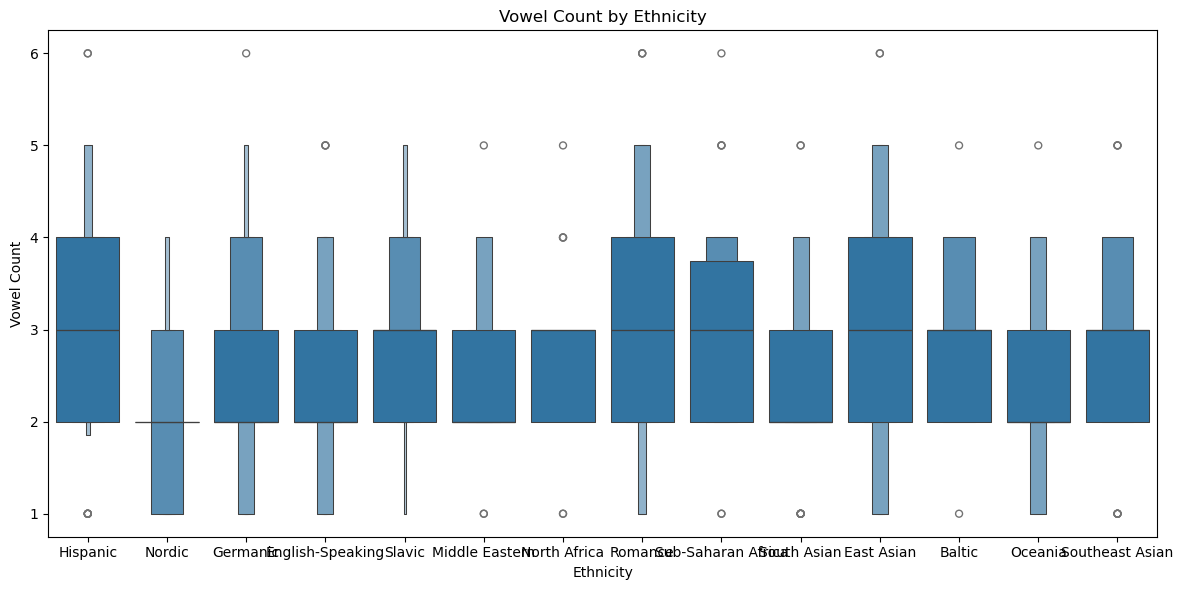

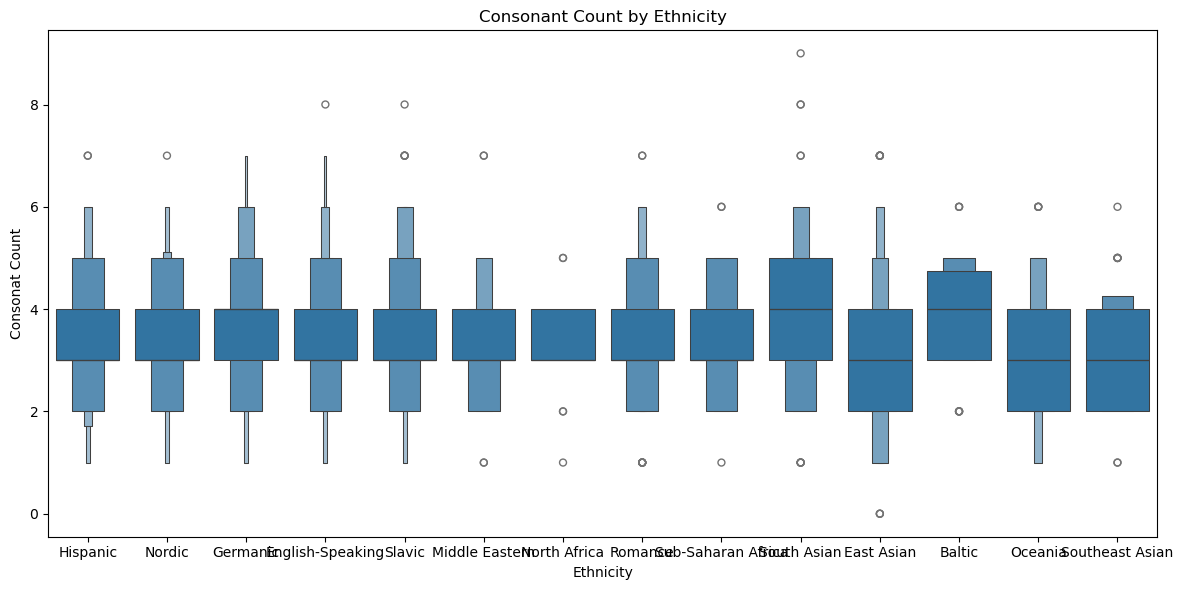

In [22]:
plt.figure(figsize=(12, 6))
sns.boxenplot(data=df_ethnicity, x='Country', y='vowel_count')
plt.title('Vowel Count by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Vowel Count')
plt.tight_layout()


plt.figure(figsize=(12, 6))
sns.boxenplot(data=df_ethnicity, x='Country', y='consonant_count')
plt.title('Consonant Count by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Consonat Count')
plt.tight_layout()



In [23]:
def get_length_stats(df:pd.DataFrame, column_name, column_groupby):
    df['name_length'] = df[column_name].apply(lambda name: len(name))
    stats_length = df.groupby(column_groupby)['name_length'].agg(['mean', 'std'])
    return stats_length

df_length = get_length_stats(df_ethnicity, column_name='Name', column_groupby='Country')

print('Length stats for names by ethnicity:')
df_length.head()

Length stats for names by ethnicity:


,mean,std
Country,,
Baltic,6.586957,1.423237
East Asian,6.078189,1.862837
English-Speaking,5.859038,1.515709
Germanic,6.134185,1.667923
Hispanic,6.356383,1.512829


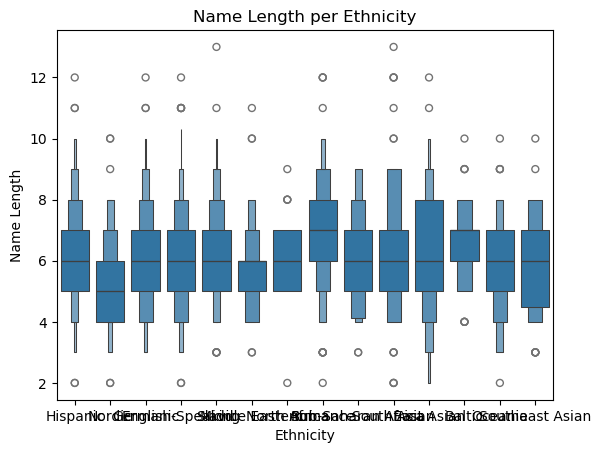

In [24]:
def create_boxenplot_by_Country(data: pd.DataFrame, column_name, abcisse):
    data['name_length'] = data[column_name].apply(lambda name: len(name))

    fig = sns.boxenplot(data, x=abcisse, y='name_length')
    fig.set_xlabel('Ethnicity')
    fig.set_ylabel('Name Length')
    fig.set_title('Name Length per Ethnicity')

create_boxenplot_by_Country(df_ethnicity, column_name='Name', abcisse='Country')

In [25]:
def create_letter_count_df(df, letter_position):

    df_letter = df.copy()
    df_letter['letter'] = df_letter['Name'].apply(lambda name: name[letter_position].lower())
    
    letter_counts_H = df_letter[df_letter['Country'] == 'ex-USSR']['letter'].value_counts()
    letter_counts_F = df_letter[df_letter['Country'] == 'British']['letter'].value_counts()

    male_count = df_letter[df_letter['Country'] == 'ex-USSR'].shape[0]
    female_count = df_letter[df_letter['Country'] == 'British'].shape[0]
    letter_counts_H_percentage = letter_counts_H / male_count*100
    letter_counts_F_percentage = letter_counts_F / female_count*100
    letter_counts = pd.concat([letter_counts_H_percentage, letter_counts_F_percentage], axis=1)
    letter_counts.columns = ['letter_men', 'letter_women']
    letter_counts = letter_counts.head(26)  # Limit to top 26 letters

    top_letter_names = (
        df_letter.groupby(['letter', 'Country'])['Name']
        .apply(lambda x: x.value_counts().head(3).index.tolist())
        .unstack(fill_value=[])
    )

    return letter_counts, top_letter_names

def plot_letter_name_percentage(df, letter_position, comparison):

    letter_counts, top_letter_names = create_letter_count_df(df, letter_position)

    if letter_position == 0:
        title = f'Percentage of Names Starting by Each Letter by {comparison}'
    else:
        title = f'Percentage of Names Ending by Each Letter by {comparison}'

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=letter_counts.index,
        y=letter_counts['letter_men'],
        name='ex-USSR',
        marker_color='salmon',
        hovertext=[f"Top names: {', '.join(top_letter_names.loc[letter, 'ex-USSR'])}" if 'ex-USSR' in top_letter_names.columns else "" for letter in letter_counts.index],
        hoverinfo="text"
    ))

    fig.add_trace(go.Bar(
        x=letter_counts.index,
        y=letter_counts['letter_women'],
        name='Brittish',
        marker_color='skyblue',
        hovertext=[f"Top names: {', '.join(top_letter_names.loc[letter, 'British'])}" if 'British' in top_letter_names.columns else "" for letter in letter_counts.index],
        hoverinfo="text"
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Letter of the Name',
        yaxis_title='% of Total Names by Ethnicity',
        barmode='group',
        yaxis=dict(ticksuffix='%'),
        legend_title="Ethnicity"
    )

    fig.show()

plot_letter_name_percentage(df_ethnicity, 0, comparison='Country')
plot_letter_name_percentage(df_ethnicity, -1, comparison='Country')
